# This is a notebook for Fig. 4 in Albright et al. in prep.

## Moist static energy and surface albedo

In [ ]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps as gvcmaps
import geocat.viz.util as gvutil
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.colors import LinearSegmentedColormap

## Read in files:

In [ ]:
#########################
# Config
#########################
PI_PATH = "/glade/u/home/malbright/nam_manuscript_figures/moist_stat_energ/final/remapped/mse_pi_lr_ne30_JJ_h03_mean_interp.remap.nc"
PLIO_PATH = "/glade/u/home/malbright/nam_manuscript_figures/moist_stat_energ/final/remapped/mse_plio_lr_ne30_JJ_h03_mean_interp.remap.nc"
PI_PATH_HR = "/glade/u/home/malbright/nam_manuscript_figures/moist_stat_energ/final/remapped/mse_pi_hr_ne120_JJ_h03_mean_interp.remap.nc"
PLIO_PATH_HR = "/glade/u/home/malbright/nam_manuscript_figures/moist_stat_energ/final/remapped/mse_plio_hr_ne120_JJ_h03_mean_interp.remap.nc"
VAR_NAME = "MSE"
TARGET_LAT = 26.0
# Longitudes to slice in native coordinates if 0–360; otherwise use wrapped
LON_SLICE_NATIVE = (235.0, 265.0)
LON_SLICE_WRAPPED = (-130.0, -95.0)  # equivalent after wrapping

OUTDIR = "figures"
OUTFILE = "final_Fig4_vert_profile_diff.png"

# Contour levels (kJ/kg)
levels_mse = np.arange(310, 351, 2)

In [ ]:
#############################
# Helpers
#############################
def standardize_coords(ds):
    ren = {}
    if "longitude" in ds.coords:
        ren["longitude"] = "lon"
    if "latitude" in ds.coords:
        ren["latitude"] = "lat"
    if "lev" in ds.coords:
        ren["lev"] = "plev"
    if "level" in ds.coords and "plev" not in ds.coords:
        ren["level"] = "plev"
    return ds.rename(ren) if ren else ds


def wrap_lon_to_180(da):
    if "lon" in da.coords:
        lon = da["lon"]
        if float(lon.max()) > 180:
            lon_new = ((lon + 180) % 360) - 180
            da = da.assign_coords(lon=lon_new).sortby("lon")
    return da


def ensure_plev_hpa(da):
    if "plev" in da.dims:
        p = da["plev"]
        if float(p.max()) > 2000:  # assume Pa -> hPa
            da = da.assign_coords(plev=p / 100.0)
        try:
            da["plev"].attrs["units"] = "hPa"
        except Exception:
            pass
    return da


def ensure_mse_kjkg(da):
    units = (da.attrs.get("units") or "").lower().replace(" ", "")
    if units in ("j/kg", "jkg^-1", "jkg-1", "jkg"):
        da = da / 1000.0
        da.attrs["units"] = "kJ/kg"
    else:
        try:
            if float(da.max()) > 1e3:  # heuristic
                da = da / 1000.0
                da.attrs["units"] = "kJ/kg"
        except Exception:
            pass
    return da


def select_lat_lon(da, target_lat, lon_slice_native, lon_slice_wrapped):
    # Latitude (nearest to 26N if multiple)
    if "lat" in da.dims and da.sizes["lat"] > 1:
        da = da.sel(lat=target_lat, method="nearest")

    # Longitude slicing in native coordinates
    if "lon" in da.dims:
        lon = da["lon"]
        if float(lon.max()) > 180:
            left, right = lon_slice_native
        else:
            left, right = lon_slice_wrapped
        # ensure increasing order for slice
        if left <= right:
            da = da.sel(lon=slice(left, right))
        else:
            da = da.sel(lon=slice(right, left))
    return da


def load_mse_section(path):
    ds = xr.open_dataset(path)
    ds = standardize_coords(ds)
    da = ds[VAR_NAME]
    da = select_lat_lon(da, TARGET_LAT, LON_SLICE_NATIVE, LON_SLICE_WRAPPED)
    da = wrap_lon_to_180(da)
    da = ensure_plev_hpa(da)
    da = ensure_mse_kjkg(da)
    return da


def sel_lon(da):
    return da.sel(lon=-101.2, method="nearest")


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n)),
    )

In [4]:
#############################
# Load
#############################
mse_plio = load_mse_section(PLIO_PATH)
mse_pi = load_mse_section(PI_PATH)
mse_plio_hr = load_mse_section(PLIO_PATH_HR)
mse_pi_hr = load_mse_section(PI_PATH_HR)

mse_plio = mse_plio.sel(plev=slice(mse_plio.plev.max(), 200))
mse_pi = mse_pi.sel(plev=slice(mse_pi.plev.max(), 200))
mse_plio_hr = mse_plio_hr.sel(plev=slice(mse_plio_hr.plev.max(), 200))
mse_pi_hr = mse_pi_hr.sel(plev=slice(mse_pi_hr.plev.max(), 200))

mse_pi_transect = sel_lon(mse_pi)
mse_plio_transect = sel_lon(mse_plio)
mse_pi_transect_hr = sel_lon(mse_pi_hr)
mse_plio_transect_hr = sel_lon(mse_plio_hr)

hr_transect = mse_plio_transect_hr - mse_pi_transect_hr
lr_transect = mse_plio_transect - mse_pi_transect

albedo_path = "/glade/work/malbright/final_nam_manuscript_files/climatology_files"

albedo_plio = xr.open_dataset(
    f"{albedo_path}/pliocene/high_res/b.e13.B1850C5CN.ne120_g16.pliohiRes.002.cam.h0.ALBEDO.0049-0059.JJ.nc"
).albedo
albedo_pi = xr.open_dataset(
    f"{albedo_path}/preindustrial/high_res/b.e13.B1850C5CN.ne120_g16.tuning.005.cam.h0.ALBEDO.0061-0071.JJ.nc"
).albedo

## Plot:

In [ ]:
#############################
# Create colormap
#############################
base_cmap = gvcmaps.WhiteYellowOrangeRed
ncolors = 30
colors = base_cmap(np.linspace(0, 1, ncolors - 3))  # leave room for 3 new colors

# define very dark brown
dark_brown = np.array([45 / 255, 30 / 255, 20 / 255, 1])  # RGBA

# grab the last original color
last_color = colors[-1]

# make two progressive blends
blend1 = 0.67 * last_color + 0.33 * dark_brown  # closer to original
blend2 = 0.33 * last_color + 0.67 * dark_brown  # closer to brown

# build new array: all but last color, then blend1, blend2, dark_brown
colors = np.vstack([colors[:-1], blend1, blend2, dark_brown])

new_cmap = mcolors.ListedColormap(colors, name="WhiteYellowOrangeRedDarkBrown")

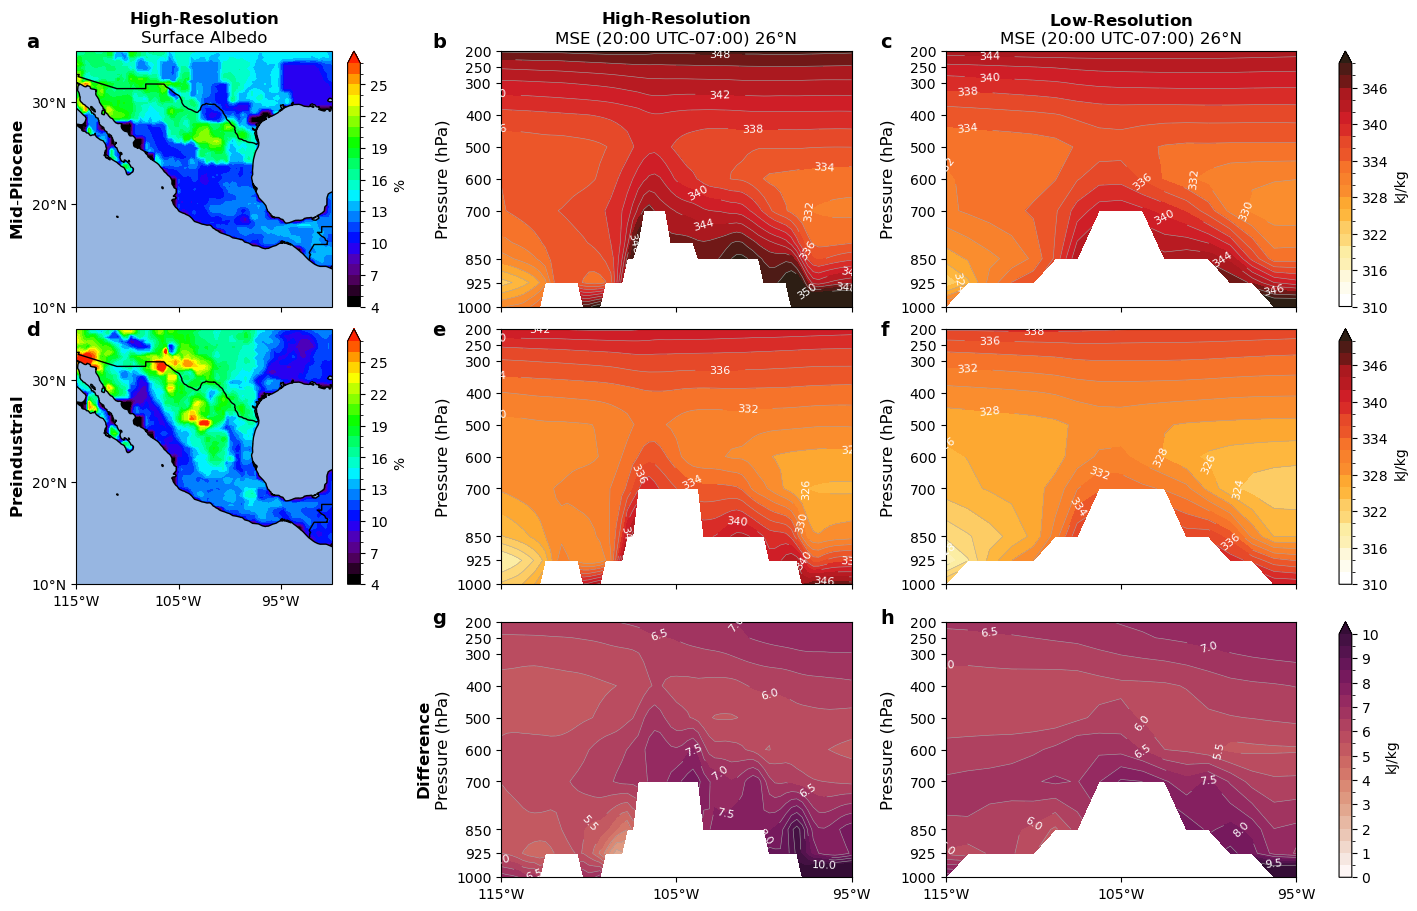

In [ ]:
#############################
# Plot
#############################
os.makedirs(OUTDIR, exist_ok=True)

fig = plt.figure(figsize=(14, 9))
fig.set_constrained_layout(True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[0.9, 1.0, 1.0])

#############################
# Column 1: Albedo maps
#############################
# Pliocene albedo (top-left)
ax_alb_plio = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_alb_plio.add_feature(cfeature.OCEAN, zorder=2)
ax_alb_plio.add_feature(cfeature.COASTLINE, zorder=4)
ax_alb_plio.add_feature(cfeature.BORDERS)
gvutil.set_axes_limits_and_ticks(
    ax_alb_plio,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-130, -90, 13),
    yticks=np.linspace(15, 50, 7),
)
ax_alb_plio.xaxis.set_tick_params(labelleft=False)
ax_alb_plio.yaxis.set_major_formatter(LatitudeFormatter())

newcmp_albedo = truncate_colormap(gvcmaps.cmaps_rainbow_gray, maxval=0.90)

levels_albedo = np.arange(4, 28, 1)
alb_kwargs = dict(
    levels=levels_albedo,
    xticks=np.arange(-115, -90, 10),
    yticks=np.arange(10, 35, 10),
    add_colorbar=False,
    extend="max",
    transform=ccrs.PlateCarree(),
)
fill_alb_plio = albedo_plio.plot.contourf(
    ax=ax_alb_plio, cmap=newcmp_albedo, **alb_kwargs
)
gvutil.set_titles_and_labels(
    ax_alb_plio,
    maintitle="",
    lefttitle="",
    xlabel="",
    ylabel=r"$\bf{Mid\text{-}Pliocene}$",
    labelfontsize=12,
)
ax_alb_plio.set_title(
    r"$\bf{High\text{-}Resolution}$" "\nSurface Albedo", fontsize=12
)
cbar_ab_plio = fig.colorbar(fill_alb_plio, ax=ax_alb_plio)
cbar_ab_plio.ax.set_ylabel("%")

# PI albedo (bottom-left)
ax_alb_pi = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax_alb_pi.add_feature(cfeature.OCEAN, zorder=2)
ax_alb_pi.add_feature(cfeature.COASTLINE, zorder=4)
ax_alb_pi.add_feature(cfeature.BORDERS)
gvutil.set_axes_limits_and_ticks(
    ax_alb_pi,
    xlim=(-115, -90),
    ylim=(10, 35),
    xticks=np.linspace(-130, -90, 13),
    yticks=np.linspace(15, 50, 7),
)
ax_alb_pi.xaxis.set_major_formatter(LongitudeFormatter())
ax_alb_pi.yaxis.set_major_formatter(LatitudeFormatter())

fill_alb_pi = albedo_pi.plot.contourf(ax=ax_alb_pi, cmap=newcmp_albedo, **alb_kwargs)
gvutil.set_titles_and_labels(
    ax_alb_pi,
    maintitle="",
    lefttitle="",
    xlabel="",
    ylabel=r"$\bf{Preindustrial}$",
    labelfontsize=12,
)
cbar_ab_pi = fig.colorbar(fill_alb_pi, ax=ax_alb_pi)
cbar_ab_pi.ax.set_ylabel("%")

#############################
# Column 2: HR MSE sections
#############################
ax_hr_plio = fig.add_subplot(gs[0, 1])
ax_hr_pi = fig.add_subplot(gs[1, 1])
ax_hr_diff = fig.add_subplot(gs[2, 1])

ax_hr_plio.xaxis.set_tick_params(labelleft=False)
ax_hr_pi.xaxis.set_tick_params(labelleft=False)
ax_hr_diff.xaxis.set_major_formatter(LongitudeFormatter())

cf_hr_plio = mse_plio_hr.plot.contourf(
    ax=ax_hr_plio, levels=levels_mse, cmap=new_cmap, add_colorbar=False, extend="max"
)
cl_hr_plio = mse_plio_hr.plot.contour(
    ax=ax_hr_plio,
    levels=levels_mse,
    colors="darkgrey",
    linewidths=0.4,
    add_labels=False,
)
gvutil.set_titles_and_labels(
    ax_hr_plio, maintitle="", lefttitle="", xlabel="", ylabel="", labelfontsize=12
)
hr_plio_texts = ax_hr_plio.clabel(
    cl_hr_plio,
    cl_hr_plio.levels,
    inline=True,
    fontsize=8,
    colors="white",
)

ax_hr_plio.set_title(
    r"$\bf{High\text{-}Resolution}$" "\nMSE (20:00 UTC-07:00) 26°N", fontsize=12
)

cf_hr_pi = mse_pi_hr.plot.contourf(
    ax=ax_hr_pi, levels=levels_mse, cmap=new_cmap, add_colorbar=False, extend="max"
)
cl_hr_pi = mse_pi_hr.plot.contour(
    ax=ax_hr_pi, levels=levels_mse, colors="darkgrey", linewidths=0.4, add_labels=False
)
gvutil.set_titles_and_labels(
    ax_hr_pi, maintitle="", lefttitle="", xlabel="", ylabel="", labelfontsize=12
)
hr_pi_texts = ax_hr_pi.clabel(
    cl_hr_pi, cl_hr_pi.levels, inline=True, fontsize=8, colors="white"
)

mse_diff_hr = mse_plio_hr - mse_pi_hr
levels_diff = np.arange(-10, 10.1, 0.5)
diff_cmap = gvcmaps.cmocean_curl

cf_hr_diff = mse_diff_hr.plot.contourf(
    ax=ax_hr_diff, levels=levels_diff, cmap=diff_cmap, add_colorbar=False, extend="max"
)
cl_hr_diff = mse_diff_hr.plot.contour(
    ax=ax_hr_diff,
    levels=levels_diff,
    colors="darkgrey",
    linewidths=0.4,
    add_labels=False,
)
gvutil.set_titles_and_labels(
    ax_hr_diff,
    maintitle="",
    lefttitle="",
    xlabel="",
    ylabel="Difference",
    labelfontsize=12,
)
hr_diff_texts = ax_hr_diff.clabel(
    cl_hr_diff, cl_hr_diff.levels, inline=True, fontsize=8, colors="white"
)

#############################
# Column 3: LR MSE sections
#############################
ax_lr_plio = fig.add_subplot(gs[0, 2])
ax_lr_pi = fig.add_subplot(gs[1, 2])
ax_lr_diff = fig.add_subplot(gs[2, 2])

ax_lr_plio.xaxis.set_tick_params(labelleft=False)
ax_lr_pi.xaxis.set_tick_params(labelleft=False)
ax_lr_diff.xaxis.set_major_formatter(LongitudeFormatter())

cf_lr_plio = mse_plio.plot.contourf(
    ax=ax_lr_plio, levels=levels_mse, cmap=new_cmap, add_colorbar=False, extend="max"
)
cl_lr_plio = mse_plio.plot.contour(
    ax=ax_lr_plio,
    levels=levels_mse,
    colors="darkgrey",
    linewidths=0.4,
    add_labels=False,
)
gvutil.set_titles_and_labels(
    ax_lr_plio, maintitle="", lefttitle="", xlabel="", ylabel="", labelfontsize=12
)
lr_plio_texts = ax_lr_plio.clabel(
    cl_lr_plio,
    cl_lr_plio.levels,
    inline=True,
    fontsize=8,
    colors="white"
)
ax_lr_plio.set_title(
    r"$\bf{Low\text{-}Resolution}$" "\nMSE (20:00 UTC-07:00) 26°N", fontsize=12
)

cf_lr_pi = mse_pi.plot.contourf(
    ax=ax_lr_pi, levels=levels_mse, cmap=new_cmap, add_colorbar=False, extend="max"
)
cl_lr_pi = mse_pi.plot.contour(
    ax=ax_lr_pi, levels=levels_mse, colors="darkgrey", linewidths=0.4, add_labels=False
)
gvutil.set_titles_and_labels(
    ax_lr_pi, maintitle="", lefttitle="", xlabel="", ylabel="", labelfontsize=12
)
lr_pi_texts = ax_lr_pi.clabel(
    cl_lr_pi, cl_lr_pi.levels, inline=True, fontsize=8, colors="white"
)

mse_diff = mse_plio - mse_pi

cf_lr_diff = mse_diff.plot.contourf(
    ax=ax_lr_diff, levels=levels_diff, cmap=diff_cmap, add_colorbar=False, extend="max"
)
cl_lr_diff = mse_diff.plot.contour(
    ax=ax_lr_diff,
    levels=levels_diff,
    colors="darkgrey",
    linewidths=0.4,
    add_labels=False,
)
gvutil.set_titles_and_labels(
    ax_lr_diff, maintitle="", lefttitle="", xlabel="", ylabel="", labelfontsize=12
)
lr_diff_texts = ax_lr_diff.clabel(
    cl_lr_diff, cl_lr_diff.levels, inline=True, fontsize=8, colors="white"
)

#############################
# Clean up clabels
#############################
for texts in [
    hr_plio_texts,
    hr_pi_texts,
    hr_diff_texts,
    lr_plio_texts,
    lr_pi_texts,
    lr_diff_texts,
]:
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    bboxes = []
    for t in texts[::-1]:
        bb = t.get_window_extent(renderer=renderer)
        if any(bb.overlaps(b) for b in bboxes):
            t.remove()
        else:
            bboxes.append(bb)

#############################
# Shared axis formatting for all MSE panels
#############################
for ax in (ax_hr_plio, ax_hr_pi, ax_hr_diff, ax_lr_plio, ax_lr_pi, ax_lr_diff):
    # invert pressure axis and use discrete plev ticks if reasonable
    if "plev" in mse_pi.dims:
        pvals = mse_pi["plev"].values
        ax.set_ylim(pvals.max(), pvals.min())
        if pvals.size <= 12:
            ax.set_yticks(pvals)

    if ax is ax_hr_diff:
        ax.set_ylabel(r"$\bf{Difference}$" "\nPressure (hPa)")
    else:
        ax.set_ylabel("Pressure (hPa)")

    ax.set_xlim(-115, -95)
    ax.set_xticks(np.arange(-115, -94, 10))

#############################
# Shared colorbars for MSE panels
#############################
# Top row (Pliocene HR + LR)
cbar_mse_top = fig.colorbar(
    cf_lr_plio,
    ax=[ax_hr_plio, ax_lr_plio],
    orientation="vertical",
    fraction=0.046,
    pad=0.03,
)
cbar_mse_top.set_label("kJ/kg", fontsize=10)

# Middle row (PI HR + LR)
cbar_mse_bot = fig.colorbar(
    cf_lr_pi, ax=[ax_hr_pi, ax_lr_pi], orientation="vertical", fraction=0.046, pad=0.03
)
cbar_mse_bot.set_label("kJ/kg", fontsize=10)

# Bottom row (diff)
cbar_mse_diff = fig.colorbar(
    cf_lr_diff,
    ticks=levels_diff[::2],
    ax=[ax_hr_diff, ax_lr_diff],
    orientation="vertical",
    fraction=0.046,
    pad=0.03,
)
cbar_mse_diff.ax.set_ylim(0, 10)

cbar_mse_diff.set_label("kJ/kg", fontsize=10)

#############################
# Panel labels
#############################
labels = ["a", "b", "c", "d", "e", "f", "g", "h"]
axes = [
    ax_alb_plio,
    ax_hr_plio,
    ax_lr_plio,
    ax_alb_pi,
    ax_hr_pi,
    ax_lr_pi,
    ax_hr_diff,
    ax_lr_diff,
]

# Offset values in figure fraction coordinates (x, y)
offsets = [
    (0.01, 0.97),  # a: top-left outside margin
    (0.30, 0.97),  # b
    (0.62, 0.97),  # c
    (0.01, 0.65),  # d: bottom-left outside margin
    (0.30, 0.65),  # e
    (0.62, 0.65),  # f
    (0.30, 0.33),  # g
    (0.62, 0.33),  # h
]

for lab, (x, y) in zip(labels, offsets):
    fig.text(x, y, lab, fontsize=14, fontweight="bold", ha="left", va="top")

#############################
# Save / Show
#############################
outfile_png = os.path.join(OUTDIR, OUTFILE)
outfile_pdf = os.path.join(OUTDIR, "final_Fig4_vert_profile_diff.pdf")
plt.savefig(outfile_png, dpi=150, bbox_inches="tight")
plt.savefig(outfile_pdf, dpi=300, bbox_inches="tight")
# plt.show()